# LXMERT VQA DEMO

This Notebook is based on the following: https://github.com/huggingface/transformers/tree/main/examples/research_projects/lxmert

LXMERT is a very accurate at the expense of computation time. Because of the use of F-RCNN to obtain regions of interest, it takes a lot of time to process an image. 

One upside to this would be for more accurate answers. For example, if we have a lot of questions about a single image then LXMERT might be good because we can quickly ask multiple questions about the same image after we've processed it.

In [45]:
from IPython.display import clear_output, Image, display
import PIL
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import torch
import io
from frcnn.utils import Config, get_data
from frcnn.modeling_frcnn import GeneralizedRCNN
from frcnn.processing_image import Preprocess
from frcnn.visualizing_image import SingleImageViz

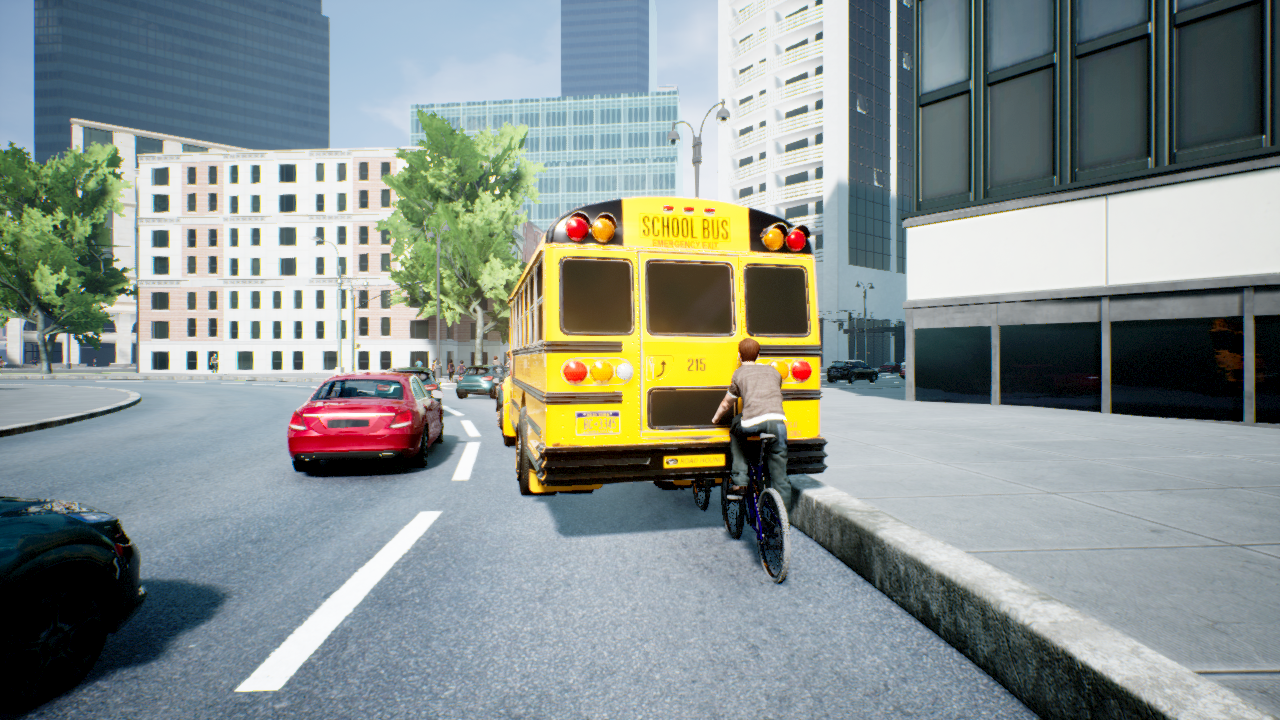

In [52]:
IMAGE_LOCATION = r"C:\Users\robin\Desktop\SeniorDesign\VisualInspectionDeepLearning\SampleImages\AirSimImage.png"
image = PIL.Image.open(IMAGE_LOCATION)

image

In [47]:
# Define the model 

lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [48]:
# Setup Faster RCNN Model for visual embeddings

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at C:\Users\robin/.cache\torch\transformers\57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [49]:
# run frcnn
images, sizes, scales_yx = image_preprocess(IMAGE_LOCATION)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

print(output_dict.keys())

odict_keys(['obj_ids', 'obj_probs', 'attr_ids', 'attr_probs', 'boxes', 'sizes', 'preds_per_image', 'roi_features', 'normalized_boxes'])


In [50]:
# Image Visualization

OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"

objids = get_data(OBJ_URL)
attrids = get_data(ATTR_URL)

frcnn_visualizer = SingleImageViz(IMAGE_LOCATION, id2obj=objids, id2attr=attrids)

# add boxes and labels to the image
frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)

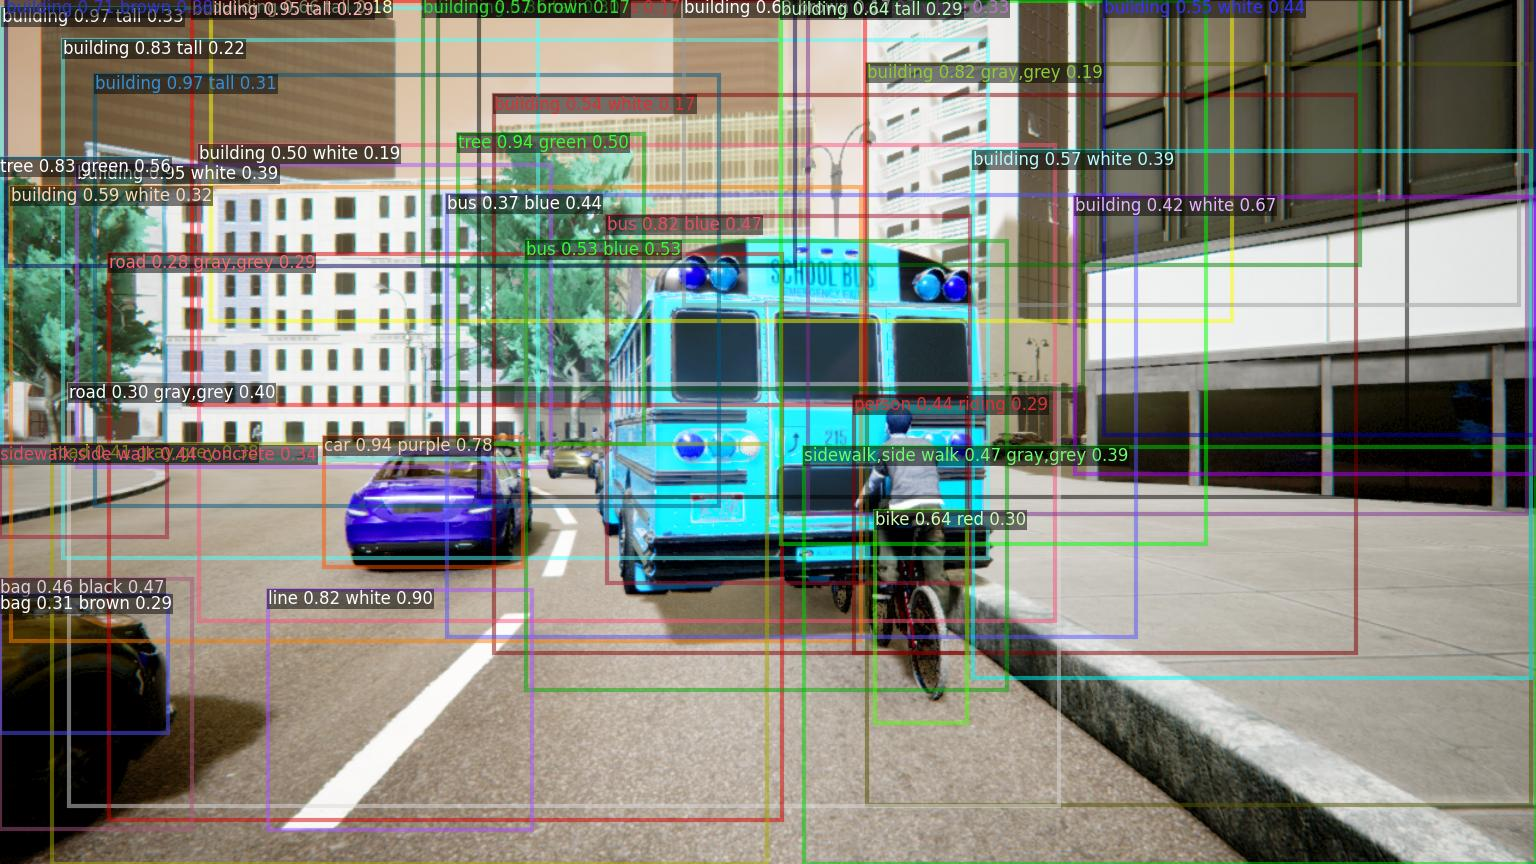

In [51]:
# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
showarray(frcnn_visualizer._get_buffer())


In [53]:
# Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

questions = ["Is there a car?",
             "What does the text on the bus say?",
             "Is the person on the bike?",
             "What color is the bus?",
             "How many trees are there?"
            ]

VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = get_data(VQA_URL)

for test_question in questions:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    # run lxmert
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])


Question: ['Is there a car?']
prediction from LXMERT VQA: yes
Question: ['What does the text on the bus say?']
prediction from LXMERT VQA: unknown
Question: ['Is the person on the bike?']
prediction from LXMERT VQA: yes
Question: ['What color is the bus?']
prediction from LXMERT VQA: blue
Question: ['How many trees are there?']
prediction from LXMERT VQA: 3
